/tmp/ipython-input-11741329.py:52: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  index = pd.date_range(start='2020-01-01', periods=n, freq='H')


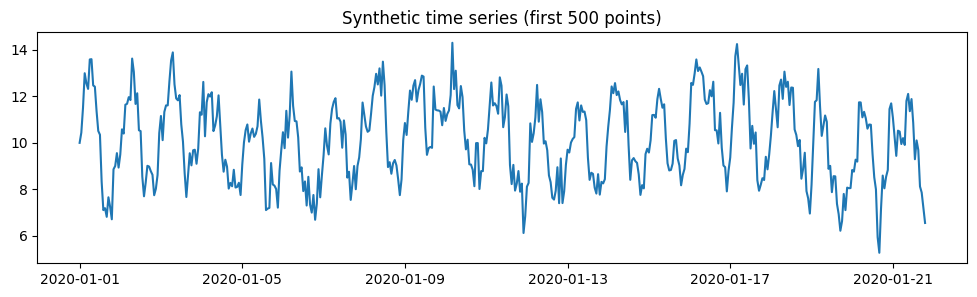

Train / Val / Test sizes: 2100, 450, 450
Shapes: (1909, 168, 2) (1909, 24) (427, 168, 2) (427, 24) (427, 168, 2) (427, 24)


/usr/local/lib/python3.12/dist-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_1 (LSTM)                   │ (None, 128)            │        67,072 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 24)             │         3,096 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 70,168 (274.09 KB)

 Trainable params: 70,168 (274.09 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/100
30/30 - 9s - 287ms/step - loss: 0.6544 - val_loss: 0.3438
Epoch 2/100
30/30 - 8s - 255ms/step - loss: 0.4241 - val_loss: 0.3227
Epoch 3/100
30/30 - 6s - 212ms/step - loss: 0.3953 - val_loss: 0.3115
Epoch 4/100
30/30 - 8s - 255ms/step - loss: 0.3806 - val_loss: 0.2973
Epoch 5/100
30/30 - 7s - 245ms/step - loss: 0.3752 - val_loss: 0.2971
Epoch 6/100
30/30 - 7s - 222ms/step - loss: 0.3593 - val_loss: 0.3087
Epoch 7/100
30/30 - 8s - 255ms/step - loss: 0.3420 - val_loss: 0.3060
Epoch 8/100
30/30 - 6s - 215ms/step - loss: 0.3317 - val_loss: 0.3002
Epoch 9/100
30/30 - 8s - 253ms/step - loss: 0.3290 - val_loss: 0.3021
Epoch 10/100
30/30 - 11s - 378ms/step - loss: 0.3295 - val_loss: 0.2796
Epoch 11/100
30/30 - 6s - 213ms/step - loss: 0.3274 - val_loss: 0.2992
Epoch 12/100
30/30 - 8s - 251ms/step - loss: 0.3224 - val_loss: 0.2890
Epoch 13/100
30/30 - 6s - 211ms/step - loss: 0.3185 - val_loss: 0.2810
Epoch 14/100
30/30 - 8s - 253ms/step - loss: 0.3146 - val_loss: 0.2938
Epoch 15/100
3

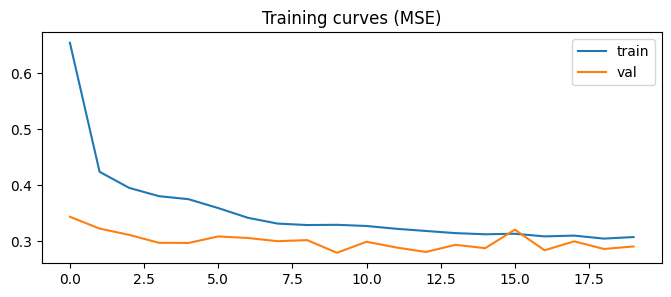

14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 103ms/step
Aggregate metrics (mean over horizon):
MAE: 1.0137032044759793
RMSE: 1.257017228587251
MAPE: 8.839541599770861


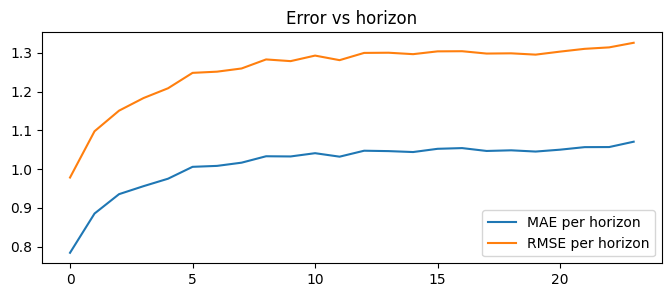

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import math
import os

# TensorFlow and statsmodels; if missing, print instructions
try:
    import tensorflow as tf
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import LSTM, Dense, Dropout
    tf.get_logger().setLevel('ERROR')
except Exception as e:
    print("TensorFlow not available in this environment. Install with: pip install tensorflow")
    tf = None # Set tf to None to indicate it's not available

try:
    import statsmodels.api as sm
    from statsmodels.tsa.statespace.sarimax import SARIMAX
except Exception as e:
    print("statsmodels not available; SARIMA baseline will be skipped. Install with: pip install statsmodels")
    sm = None

# SHAP optional
try:
    import shap
    shap_available = True
except Exception:
    shap_available = False

# 1) Generate synthetic time series (hourly) with trend + seasonality + AR noise

np.random.seed(42)
n = 3000  # length >= 1000
t = np.arange(n)

trend = 0.0005 * t  # small trend
seasonal_daily = 2.0 * np.sin(2 * np.pi * t / 24)
seasonal_weekly = 0.8 * np.sin(2 * np.pi * t / (24*7))
# AR(1) noise

phi = 0.6
eps = np.random.normal(scale=0.8, size=n)
ar = np.zeros(n)
for i in range(1, n):
    ar[i] = phi * ar[i-1] + eps[i]

series = 10 + trend + seasonal_daily + seasonal_weekly + ar

index = pd.date_range(start='2020-01-01', periods=n, freq='H')
df = pd.DataFrame({'y': series}, index=index)

# Add an exogenous feature (temperature-like)

temp = 20 + 5 * np.sin(2 * np.pi * (t + 50) / 24) + np.random.normal(scale=0.5, size=n)
df['temp'] = temp

# Quick plot

plt.figure(figsize=(12,3))
plt.plot(df['y'].iloc[:500])
plt.title('Synthetic time series (first 500 points)')
plt.show()

# 2) Train/val/test split (time-based)

train_frac = 0.7
val_frac = 0.15
n_train = int(len(df) * train_frac)
n_val = int(len(df) * (train_frac + val_frac))

train_df = df.iloc[:n_train]
val_df = df.iloc[n_train:n_val]
test_df = df.iloc[n_val:]

print(f"Train / Val / Test sizes: {len(train_df)}, {len(val_df)}, {len(test_df)}")

# 3) Scaling

feature_cols = ['y', 'temp']
scaler = StandardScaler()
scaler.fit(train_df[feature_cols])

def scale_df(input_df):
    arr = scaler.transform(input_df[feature_cols])
    return pd.DataFrame(arr, index=input_df.index, columns=feature_cols)

train_s = scale_df(train_df)
val_s = scale_df(val_df)
test_s = scale_df(test_df)
# 4) Windowing helper (direct multi-output)

def make_windows(df_scaled, lookback=168, horizon=24, target_col='y'):
    X, Y = [], []
    arr = df_scaled.values
    for i in range(0, len(arr) - lookback - horizon + 1):
        X.append(arr[i:i+lookback, :]) # target is the univariate 'y' column assumed at index 0
        Y.append(arr[i+lookback:i+lookback+horizon, 0])
    return np.array(X), np.array(Y)

LOOKBACK = 168  # one week of hourly data
HORIZON = 24    # predict next 24 hours

X_train, Y_train = make_windows(train_s, LOOKBACK, HORIZON)
X_val, Y_val = make_windows(pd.concat([train_s.tail(LOOKBACK), val_s]), LOOKBACK, HORIZON)
X_test, Y_test = make_windows(pd.concat([val_s.tail(LOOKBACK), test_s]), LOOKBACK, HORIZON)

print('Shapes:', X_train.shape, Y_train.shape, X_val.shape, Y_val.shape, X_test.shape, Y_test.shape)

# 5) Build LSTM model (direct multi-output)
n_features = X_train.shape[2]
model = Sequential([
    LSTM(128, input_shape=(LOOKBACK, n_features), return_sequences=False),
    Dropout(0.2),
    Dense(HORIZON)
])
model.compile(optimizer='adam', loss='mse')
model.summary()

# 6) Train with early stopping
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True),
]
history = model.fit(X_train, Y_train, epochs=100, batch_size=64, validation_data=(X_val, Y_val), callbacks=callbacks, verbose=2)

# Plot training curves
plt.figure(figsize=(8,3))
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='val')
plt.legend()
plt.title('Training curves (MSE)')
plt.show()

# 7) Predictions on test set
Y_pred_test = model.predict(X_test)

# Inverse scale the target (remember scaler applied to both y and temp; y is column 0)
# To invert, we need to inverse transform using the scaler's mean and scale for the y column
y_mean = scaler.mean_[0]
y_std = np.sqrt(scaler.var_[0])

Y_test_inv = Y_test * y_std + y_mean
Y_pred_inv = Y_pred_test * y_std + y_mean

# 8) Evaluation metrics (per horizon and aggregate)

def compute_metrics(y_true, y_pred):
    # y_true, y_pred shapes (n_samples, horizon)
    n, h = y_true.shape
    mae_per_h = np.mean(np.abs(y_true - y_pred), axis=0)
    rmse_per_h = np.sqrt(np.mean((y_true - y_pred)**2, axis=0))
    # MAPE with small epsilon
    mape_per_h = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + 1e-8)), axis=0) * 100
    return mae_per_h, rmse_per_h, mape_per_h

mae_h, rmse_h, mape_h = compute_metrics(Y_test_inv, Y_pred_inv)

print('Aggregate metrics (mean over horizon):')
print('MAE:', np.mean(mae_h))
print('RMSE:', np.mean(rmse_h))
print('MAPE:', np.mean(mape_h))

# Plot error vs horizon

plt.figure(figsize=(8,3))
plt.plot(mae_h, label='MAE per horizon')
plt.plot(rmse_h, label='RMSE per horizon')
plt.legend()
plt.title('Error vs horizon')
plt.show()